In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [22]:
# Load the updated dataset
df = pd.read_csv("us_voters_with_votes_sample_data.csv")

total_votes = df['2024 Presidential Vote'].count()
trump_count = df['2024 Presidential Vote'].value_counts().get('Donald Trump', 0)
harris_count = df['2024 Presidential Vote'].value_counts().get('Kamala Harris', 0)

trump_percentage = (trump_count / total_votes) * 100 if total_votes > 0 else 0
harris_percentage = (harris_count / total_votes) * 100 if total_votes > 0 else 0

# Display the counts and percentages
print(f"Number of votes for Donald Trump: {trump_count} ({trump_percentage:.2f}%)")
print(f"Number of votes for Kamala Harris: {harris_count} ({harris_percentage:.2f}%)")

Number of votes for Donald Trump: 1467 (48.38%)
Number of votes for Kamala Harris: 1337 (44.10%)


Average Republican support rate after bootstrap: 48.41%
Average Democrat support rate after bootstrap: 44.07%


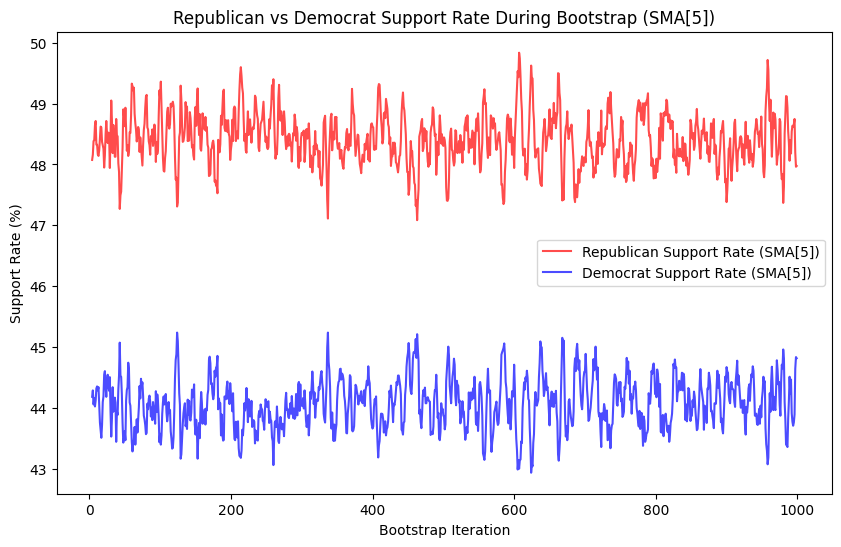

In [25]:
# Defining candidate-party mapping
party_mapping = {
    'Donald Trump': 'Republican',
    'Kamala Harris': 'Democrat',
    'Jill Stein': 'Other',
    'Blank/null/won\'t vote': 'No Vote',
    'Cornel West': 'Other',
    'Chase Oliver': 'Other',
    'Don\'t know': 'Undecided'
}

# Map each candidate to their respective party
df['Party'] = df['2024 Presidential Vote'].map(party_mapping)

# Perform bootstrap simulation
bootstrap_iterations = 1000
rep_support_rates = []
dem_support_rates = []

np.random.seed(888)

for _ in range(bootstrap_iterations):
    sample = df.sample(n=len(df), replace=True)
    party_counts = sample['Party'].value_counts(normalize=True) * 100
    rep_support_rates.append(party_counts.get('Republican', 0))
    dem_support_rates.append(party_counts.get('Democrat', 0))
    
# Calculate average support rates
avg_rep_support_rate = np.mean(rep_support_rates)
avg_dem_support_rate = np.mean(dem_support_rates)

# Display the average support rates
print(f"Average Republican support rate after bootstrap: {avg_rep_support_rate:.2f}%")
print(f"Average Democrat support rate after bootstrap: {avg_dem_support_rate:.2f}%")
# Plot the line graph of support rates during bootstrap
rep_sma = pd.Series(rep_support_rates).rolling(window=5).mean()
dem_sma = pd.Series(dem_support_rates).rolling(window=5).mean()

plt.figure(figsize=(10, 6))
plt.plot(rep_sma, label='Republican Support Rate (SMA[5])', color='red', alpha=0.7)
plt.plot(dem_sma, label='Democrat Support Rate (SMA[5])', color='blue', alpha=0.7)
plt.xlabel('Bootstrap Iteration')
plt.ylabel('Support Rate (%)')
plt.title('Republican vs Democrat Support Rate During Bootstrap (SMA[5])')
plt.legend()
plt.show()


In [24]:
# Perform bootstrap simulation
bootstrap_iterations = 1000
winning_counts = {'Republican': 0, 'Democrat': 0, 'Other': 0, 'No Vote': 0, 'Undecided': 0}

np.random.seed(888)  # for reproducibility

for _ in range(bootstrap_iterations):
    sample = df.sample(n=len(df), replace=True)
    winner = sample['Party'].value_counts().idxmax()
    winning_counts[winner] += 1

# Determine the party with the highest winning rate
total_simulations = sum(winning_counts.values())
winning_rates = {party: count / total_simulations for party, count in winning_counts.items()}
highest_winning_party = max(winning_rates, key=winning_rates.get)

# Display the results
winning_rates, highest_winning_party

({'Republican': 0.9929,
  'Democrat': 0.0071,
  'Other': 0.0,
  'No Vote': 0.0,
  'Undecided': 0.0},
 'Republican')

In [18]:
# Map each candidate to their respective party
df['Party'] = df['2024 Presidential Vote'].map(party_mapping)

# Prepare data for model training
# Filtering dataset to only include Republican and Democrat votes
df_filtered = df[df['Party'].isin(['Republican', 'Democrat'])]

# Encoding categorical features
X = pd.get_dummies(df_filtered[['Gender', 'Age', 'Yearly Household Income', 'Education Level', 'Region', 'Race']], drop_first=True)
y = df_filtered['Party'].map({'Republican': 1, 'Democrat': 0})

# Save the feature names for consistency
feature_columns = X.columns

# Feature scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Logistic Regression model with hyperparameter tuning
logreg = LogisticRegression()
param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best model from grid search
best_logreg = grid_search.best_estimator_

# Train Gradient Boosting Classifier
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train, y_train)

# Train Random Forest Classifier
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

# Create Stacking Classifier
estimators = [('logreg', best_logreg), ('gbc', gbc), ('rfc', rfc)]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=5)
stacking_clf.fit(X_train, y_train)

# Predict on the test set using stacking classifier
y_pred_stacking = stacking_clf.predict(X_test)

# Evaluate the stacking classifier
accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
print(f"Accuracy of Stacking Classifier: {accuracy_stacking:.2f}")
print("Classification Report (Stacking Classifier):")
print(classification_report(y_test, y_pred_stacking))
print("Confusion Matrix (Stacking Classifier):")
print(confusion_matrix(y_test, y_pred_stacking))

# Perform bootstrap simulation
bootstrap_iterations = 1000
rep_support_rates = []
dem_support_rates = []
y_true_bootstrap = []
y_pred_bootstrap = []

np.random.seed(888)  # for reproducibility

for _ in range(bootstrap_iterations):
    sample = df.sample(n=len(df), replace=True)
    sample_X = pd.get_dummies(sample[['Gender', 'Age', 'Yearly Household Income', 'Education Level', 'Region', 'Race']], drop_first=True)
    # Align sample_X with the feature columns used during training
    sample_X = sample_X.reindex(columns=feature_columns, fill_value=0)
    sample_X = scaler.transform(sample_X)
    party_counts = sample['Party'].value_counts(normalize=True) * 100
    rep_support_rates.append(party_counts.get('Republican', 0))
    dem_support_rates.append(party_counts.get('Democrat', 0))
    y_true_bootstrap.append(sample['Party'].map({'Republican': 1, 'Democrat': 0}).fillna(0).astype(int))
    y_pred_bootstrap.append(stacking_clf.predict(sample_X))

# Flatten lists of true and predicted values
y_true_bootstrap = np.concatenate(y_true_bootstrap)
y_pred_bootstrap = np.concatenate(y_pred_bootstrap)

# Calculate accuracy and confusion matrix after bootstrapping
bootstrap_accuracy = accuracy_score(y_true_bootstrap, y_pred_bootstrap)
bootstrap_confusion_matrix = confusion_matrix(y_true_bootstrap, y_pred_bootstrap)

# Display bootstrap evaluation results
print(f"Accuracy after bootstrapping: {bootstrap_accuracy:.2f}")
print("Confusion Matrix after bootstrapping:")
print(bootstrap_confusion_matrix)

Accuracy of Stacking Classifier: 0.54
Classification Report (Stacking Classifier):
              precision    recall  f1-score   support

           0       0.55      0.10      0.17       397
           1       0.54      0.93      0.68       445

    accuracy                           0.54       842
   macro avg       0.54      0.51      0.42       842
weighted avg       0.54      0.54      0.44       842

Confusion Matrix (Stacking Classifier):
[[ 40 357]
 [ 33 412]]
Accuracy after bootstrapping: 0.53
Confusion Matrix after bootstrapping:
[[ 208611 1355545]
 [  54782 1413062]]


Average Republican support rate after bootstrap: 48.41%
Average Democrat support rate after bootstrap: 44.07%


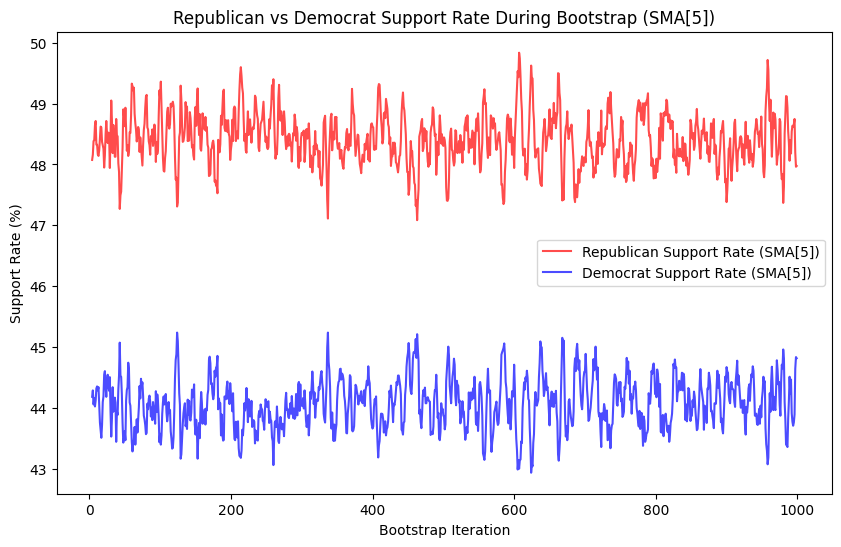

In [19]:
# Calculate average support rates
avg_rep_support_rate = np.mean(rep_support_rates)
avg_dem_support_rate = np.mean(dem_support_rates)

# Display the average support rates
print(f"Average Republican support rate after bootstrap: {avg_rep_support_rate:.2f}%")
print(f"Average Democrat support rate after bootstrap: {avg_dem_support_rate:.2f}%")

# Calculate Simple Moving Average (SMA) with window size 5
rep_sma = pd.Series(rep_support_rates).rolling(window=5).mean()
dem_sma = pd.Series(dem_support_rates).rolling(window=5).mean()

# Plot the line graph of SMA support rates during bootstrap
plt.figure(figsize=(10, 6))
plt.plot(rep_sma, label='Republican Support Rate (SMA[5])', color='red', alpha=0.7)
plt.plot(dem_sma, label='Democrat Support Rate (SMA[5])', color='blue', alpha=0.7)
plt.xlabel('Bootstrap Iteration')
plt.ylabel('Support Rate (%)')
plt.title('Republican vs Democrat Support Rate During Bootstrap (SMA[5])')
plt.legend()
plt.show()